# Incidence du syndrome grippal

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import isoweek

## Lecture des données

Les données de l'incidence du syndrome grippal sont disponibles du site Web du [Réseau Sentinelles](https://www.sentiweb.fr/france). Nous les récupérons sous forme d'un fichier en format CSV dont chaque ligne correspond à une semaine de la période demandée. Nous téléchargeons toujours le jeu de données complet, qui commence en 1990 et se termine avec une semaine récente.

In [2]:
# Récupération du nom du fichier à partir du path d'accès aux données
from os.path import basename

# URL des données
data_url = "http://www.sentiweb.fr/datasets/incidence-PAY-7.csv"

filename = basename(data_url)
filename

'incidence-PAY-7.csv'

In [3]:
# Si le fichier existe en local on le lit directement
# Sinon on l'accède avec son URL et on le sauvegarde en local

# La première ligne du fichier CSV est un commentaire, que nous ignorons en précisant skiprows=1.
import os

if os.path.exists(filename):
    print(filename, "exist")
    raw_data = pd.read_csv(filename, skiprows=1)
else:
    print(filename, "doesn't exist")
    raw_data = pd.read_csv(data_url, skiprows=1)
    raw_data.to_csv(filename)

incidence-PAY-7.csv doesn't exist


In [4]:
# On recherche les lignes avec les valeurs manquantes
raw_data[raw_data.isnull().any(axis=1)]

Empty DataFrame
Columns: [week, indicator, inc, inc_low, inc_up, inc100, inc100_low, inc100_up, geo_insee, geo_name]
Index: []

In [5]:
data = raw_data.dropna().copy()

## Vérification des données

Les données utilisent une convention inhabituelle: le numéro de semaine est collé à l'année, donnant l'impression qu'il s'agit de nombre entier. C'est comme ça que Pandas les interprète.
Un deuxième problème est que Pandas ne comprend pas les numéros de semaine. Il faut lui fournir les dates de début et de fin de semaine. Nous utilisons pour cela la bibliothèque `isoweek`.
Comme la conversion des semaines est devenu assez complexe, nous écrivons une petite fonction Python pour cela. Ensuite, nous l'appliquons à tous les points de nos donnés. Les résultats vont dans une nouvelle colonne 'period'.

In [6]:
# Ajout d'une colonne avec la période concernée par chaque semaine
def convert_week(year_and_week_int):
    year_and_week_str = str(year_and_week_int)
    year = int(year_and_week_str[:4])
    week = int(year_and_week_str[4:])
    w = isoweek.Week(year, week)
    return pd.Period(w.day(0), 'W')
    
data['period'] = [convert_week(yw) for yw in data['week']]
sorted_data = data.set_index('period').sort_index()
sorted_data.head()

week  indicator    inc  inc_low  inc_up  inc100  \
period                                                                     
1990-12-03/1990-12-09  199049          7   1143        0    2610       2   
1990-12-10/1990-12-16  199050          7  11079     6660   15498      20   
1990-12-17/1990-12-23  199051          7  19080    13807   24353      34   
1990-12-24/1990-12-30  199052          7  19375    13295   25455      34   
1990-12-31/1991-01-06  199101          7  15565    10271   20859      27   

                       inc100_low  inc100_up geo_insee geo_name  
period                                                           
1990-12-03/1990-12-09           0          5        FR   France  
1990-12-10/1990-12-16          12         28        FR   France  
1990-12-17/1990-12-23          25         43        FR   France  
1990-12-24/1990-12-30          23         45        FR   France  
1990-12-31/1991-01-06          18         36        FR   France

In [8]:
# On verifie si les périodes sont consécutives (i.e. s'il manque des semaines)
periods = sorted_data.index
for p1, p2 in zip (periods[:-1], periods[1:]):
    delta = p2.to_timestamp() - p1.end_time
    if delta > pd.Timedelta('1s'):
        print(p1, p2)

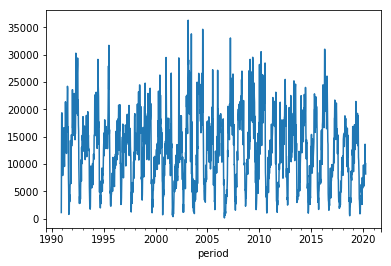

In [9]:
# plot de l'incidence par semaine
sorted_data['inc'] = sorted_data['inc'].astype(int)
sorted_data['inc'].plot();

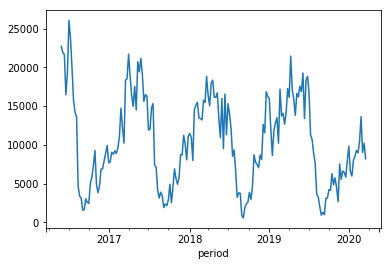

In [10]:
# On regarde uniquement les 200 dernières semaines
sorted_data['inc'][-200:].plot();

## Etude de l'incidence annuelle
Etant donné que le pic de l'épidémie se situe en hiver, à cheval
entre deux années civiles, nous définissons la période de référence
entre deux minima de l'incidence, du 1er septembre de l'année $N$ au
1er août de l'année $N+1$.

Notre tâche est un peu compliquée par le fait que l'année ne comporte
pas un nombre entier de semaines. Nous modifions donc un peu nos périodes
de référence: à la place du 1er août de chaque année, nous utilisons le
premier jour de la semaine qui contient le 1er août.

Comme l'incidence de syndrome grippal est très faible en été, cette
modification ne risque pas de fausser nos conclusions.

Encore un petit détail: les données commencent an octobre 1984, ce qui
rend la première année incomplète. Nous commençons donc l'analyse en 1985.

In [11]:
# Les années qui n'ont pas autour de 52 semaines sont ignorées
year = []
yearly_incidence = []
first_august_week = [pd.Period(pd.Timestamp(y, 9, 1), 'W')
                     for y in range(sorted_data.index[0].year,
                                    sorted_data.index[-1].year)]

for week1, week2 in zip(first_august_week[:-1], first_august_week[1:]):
    one_year = sorted_data['inc'][week1:week2-1]
    #les années doivent faire autour de 52 semaines 
    try:
        assert abs(len(one_year)-52) < 2
        yearly_incidence.append(one_year.sum())
        year.append(week2.year)
    except AssertionError:
        print("incorrect year", week2.year)
    
yearly_incidence = pd.Series(index=year, data=yearly_incidence)

incorrect year 1991


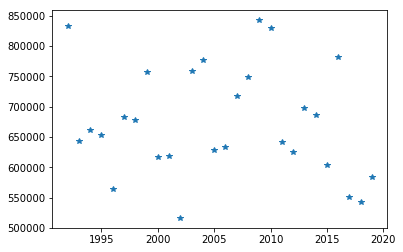

In [12]:
# plot the data
yearly_incidence.plot(style='*');

In [13]:
# recherche des années avec les épisodes les plus importants
yearly_incidence.sort_values(ascending=False)[:3]

2009    842373
1992    832939
2010    829911
dtype: int64

In [15]:
# recherche des années avec les épisodes les moins importants
yearly_incidence.sort_values(ascending=True)[:3]

2002    516689
2018    542312
2017    551041
dtype: int64

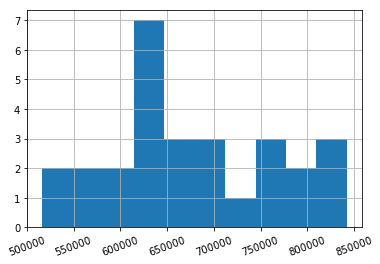

In [14]:
# histogramme des épisodes
yearly_incidence.hist(xrot=20);